In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist
import pymc3 as pm
# import pymc3.sampling_jax

import pandas as pd
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import cmdstanpy as stan
import seaborn as sns
import arviz as az

from tqdm import tqdm

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
# Default to double precision.
numpyro.enable_x64()

# Utility models

In [4]:
def u_pow(x, theta): return x**theta

In [5]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [6]:
def u_lin(x, theta=None): return x

# Generate choice data

In [7]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [8]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [9]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [10]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [11]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

## Generate data

In [12]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [13]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=100, replace=False)

In [14]:
optimize(data, u_m=u_pow)

array([3.4444072 , 0.39557323])

## Using Pymc3

In [53]:
def run_inference_pymc3(data, u_model, theta_model, tau_model):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    X = x_sorted.reshape(-1, 1)
    uX = u_model(X, theta_model)
    factor = np.dot(uX, uX.T)

    n = len(y)
    
    with pm.Model() as model:

        # ρ = pm.InverseGamma('ρ', 2, 2)
        # η = pm.HalfCauchy('η', 5)
        ρ = pm.Bound(pm.Normal, lower=0)('ρ', 1, 1)
        η = pm.Bound(pm.Normal, lower=0)('η', 1, 1)
        
        M = pm.gp.mean.Constant(uX.flatten())
        K = factor *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

        gp = pm.gp.Latent(mean_func=M, cov_func=K)
        f = gp.prior("f", X=X)

        est_eu_sorted =  p_sorted * f    
        est_eu = est_eu_sorted[undo_sorted]
        est_diff_eu = est_eu[n:] - est_eu[:n]

        choose_1 = pm.Bernoulli('obs', logit_p=tau_model*est_diff_eu, observed=y)

    with model:
        # trace = pymc3.sampling_jax.sample_tfp_nuts(1000, tune=1000, chains=1, target_accept=0.90)
        trace = pm.sample(1000, tune=1000, chains=1, 
                          return_inferencedata=True, target_accept=0.90)
    return X, trace

### 'Good' prior

In [54]:
u_model = u_pow
theta_model = 0.5
tau_model = 3.333

X, trace = run_inference_pymc3(data=data, u_model=u_model, theta_model=theta_data, tau_model=tau_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, η, ρ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 223 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [55]:
f_samples = np.array(trace.posterior["f"])
f_samples = f_samples.reshape(f_samples.shape[0]*f_samples.shape[1], -1)

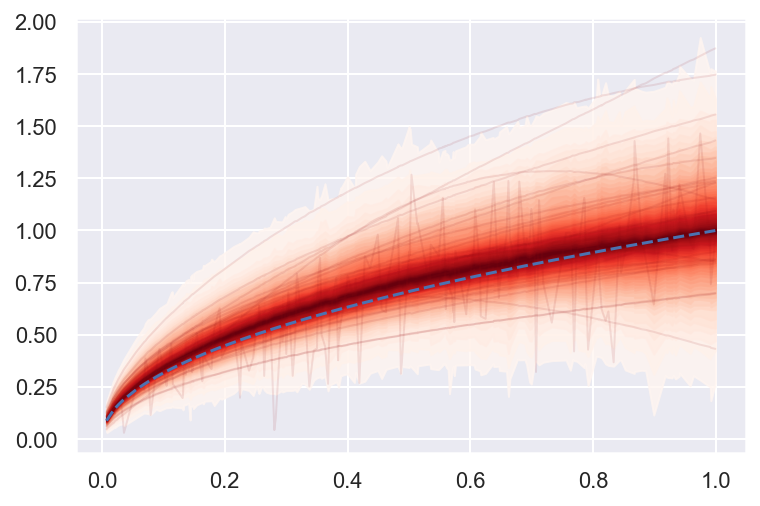

In [56]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta=theta_model), ls="--");

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

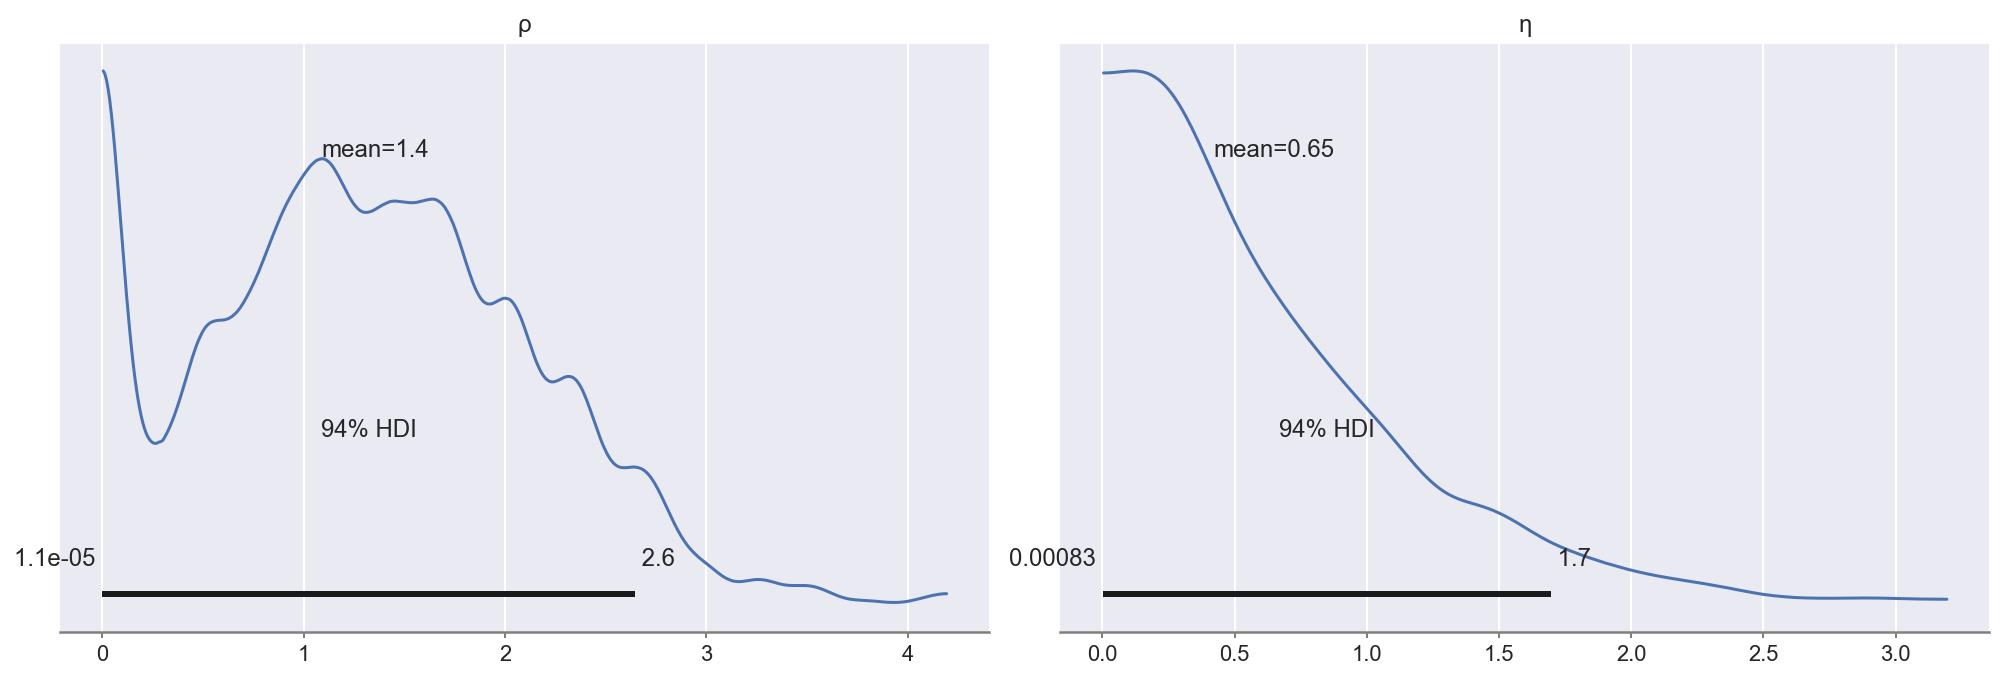

In [57]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

### Linear prior

In [58]:
u_model = u_lin
theta_model = None
tau_model = 3.333

X, trace = run_inference_pymc3(data=data, u_model=u_model, theta_model=theta_model, tau_model=tau_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, η, ρ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 319 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [59]:
f_samples = np.array(trace.posterior["f"])
f_samples = f_samples.reshape(f_samples.shape[0]*f_samples.shape[1], -1)

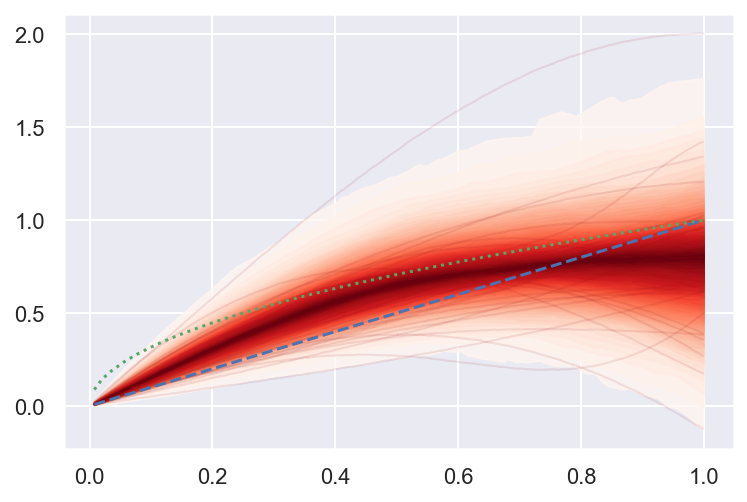

In [60]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(X, u_data(X, theta=theta_data), ls=':', color="C2")

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

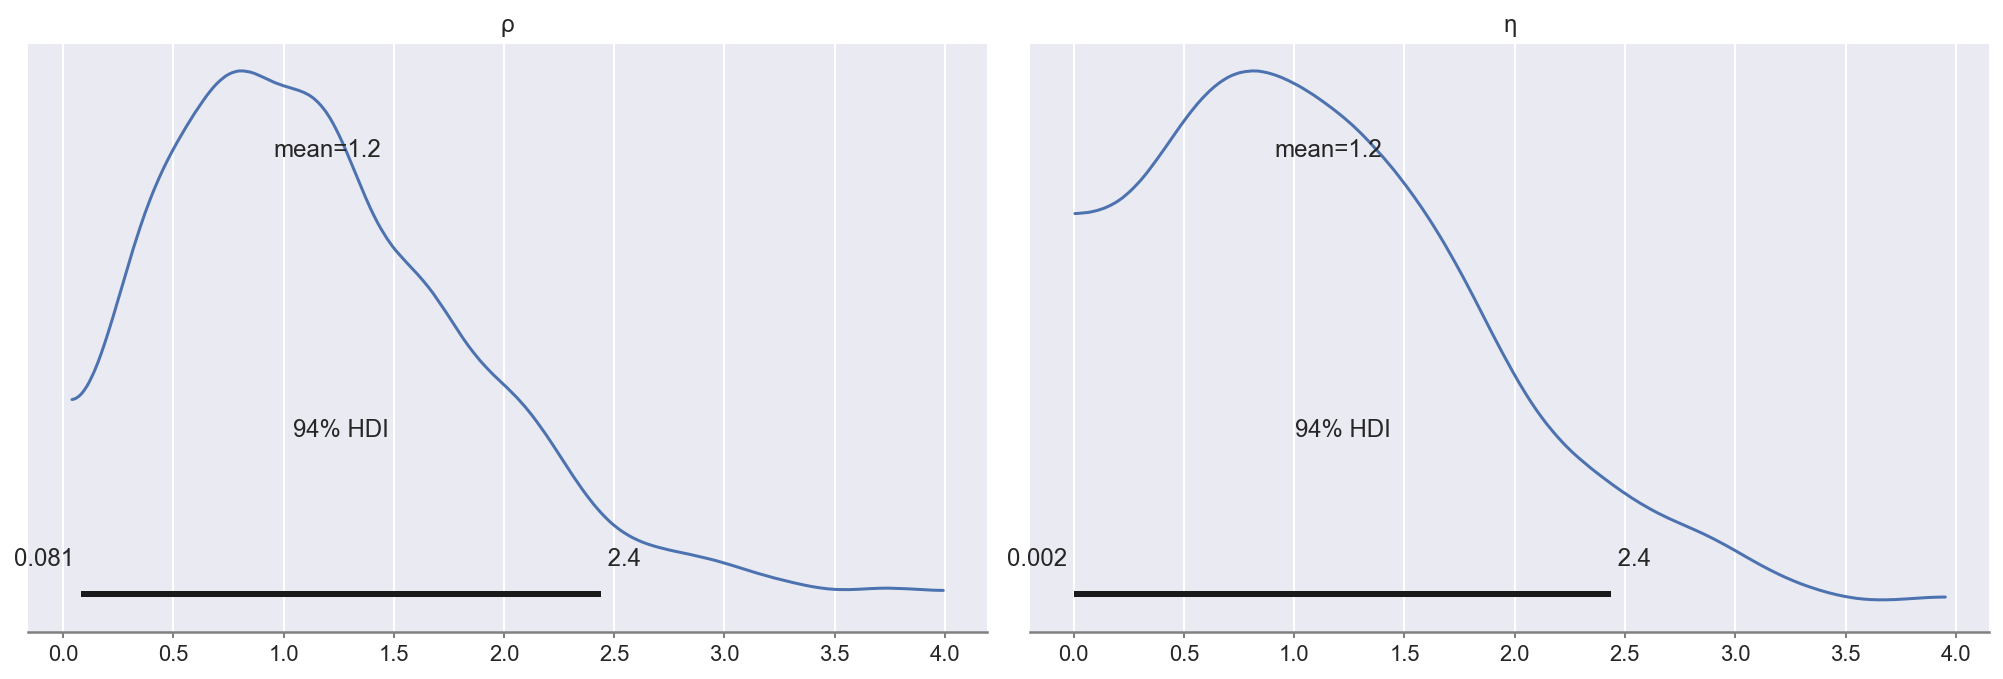

In [61]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

## Using numpyro

In [15]:
def kernel(X, Xs, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    return jnp.exp(-0.5 * deltaX)

In [16]:
def model(X, y, p, M, factor, undo_sorted, tau, jitter=1e-06):
    
    n_x = X.shape[0]
    n_y = y.shape[0]
    
    var = numpyro.sample('kernel_var', dist.TruncatedNormal(low=0, loc=1., scale=1.))
    length = numpyro.sample('kernel_length', dist.TruncatedNormal(low=0, loc=1., scale=1.))
    
    with numpyro.plate("-", n_x):
        eta = numpyro.sample('eta', dist.Normal(0, 1))
    
    K = factor * var**2 * kernel(X, X, length) + jitter * jnp.eye(n_x)
    L = jnp.linalg.cholesky(K)
    f = numpyro.deterministic("f", M + L.dot(eta))
    
    est_eu_sorted =  p * f    
    est_eu = est_eu_sorted[undo_sorted]

    est_diff_eu = est_eu[n_y:] - est_eu[:n_y]
    numpyro.sample("obs", dist.Bernoulli(logits=tau*est_diff_eu), obs=y)

In [17]:
def run_inference(data, u, theta, tau, use_ratio=True):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    X = jnp.array(x_sorted)
    uX = jnp.array(u(X, theta))
    P = jnp.array(p_sorted)
    Y = jnp.array(y)

    M = uX
    
    if use_ratio:
        factor = uX * uX[:, None]
    else:
        factor = 1.

    rng_key = random.PRNGKey(0)

    nuts = MCMC(NUTS(model, target_accept_prob=0.9, max_tree_depth=10, 
                     init_strategy=init_to_uniform(radius=1),
                     adapt_mass_matrix=True,
                     dense_mass=False,),  # Default = 2
                num_samples=1000, num_warmup=1000)
    nuts.run(rng_key, X=X, y=Y, p=P, M=M, factor=factor, tau=tau, 
             undo_sorted=undo_sorted)
    return X, nuts

In [18]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=100, replace=False)

optimize(data, u_m=u_pow)

array([3.4444072 , 0.39557323])

### Using 'good' prior

In [19]:
u_model = u_pow
theta_model = 0.5
tau_model = 3.333

X, nuts = run_inference(data=data, u=u_model, theta=theta_model, tau=tau_model)
samples = nuts.get_samples()

sample: 100%|██████████| 2000/2000 [03:49<00:00,  8.70it/s, 31 steps of size 1.75e-01. acc. prob=0.94]


In [20]:
f_samples = samples["f"]

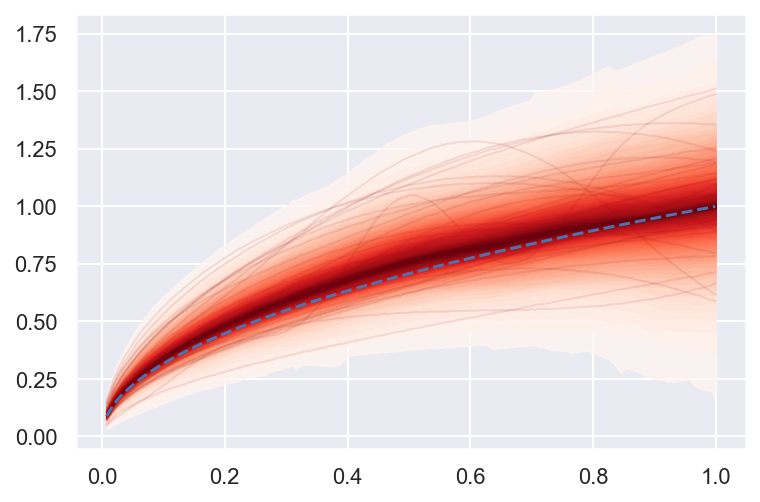

In [21]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta_model), ls='--');

In [22]:
nuts.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
         eta[0]      0.18      0.66      0.19     -1.07      1.12   1196.73      1.00
         eta[1]     -0.01      0.96     -0.01     -1.52      1.56   2030.54      1.00
         eta[2]      0.00      0.93     -0.02     -1.47      1.58   2357.51      1.00
         eta[3]     -0.04      0.92     -0.01     -1.55      1.45   1823.99      1.00
         eta[4]     -0.02      1.02     -0.00     -1.69      1.60   2582.50      1.00
         eta[5]     -0.01      0.95     -0.01     -1.52      1.53   2170.70      1.00
         eta[6]      0.00      0.93      0.00     -1.56      1.47   2461.69      1.00
         eta[7]     -0.00      0.99     -0.02     -1.51      1.73   2240.61      1.00
         eta[8]     -0.02      1.06     -0.04     -1.62      1.75   3698.27      1.00
         eta[9]      0.03      0.98      0.04     -1.51      1.72   2039.18      1.00
        eta[10]      0.01      0.98      0.02     -1.

array([<AxesSubplot:title={'center':'kernel_var'}>,
       <AxesSubplot:title={'center':'kernel_length'}>], dtype=object)

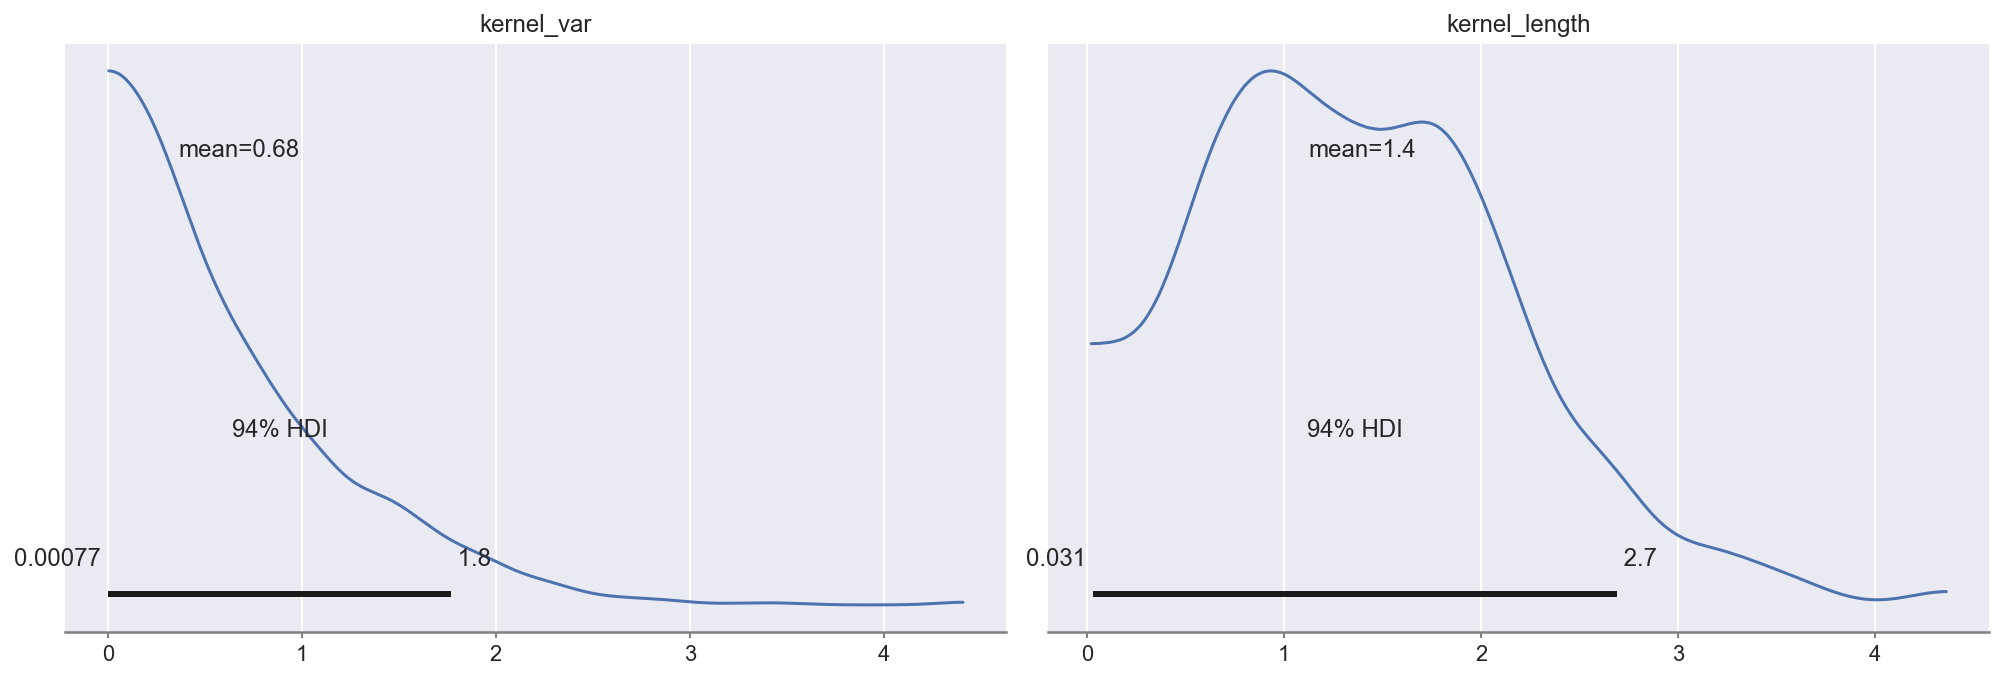

In [23]:
az_samples = az.from_numpyro(nuts)
az.plot_posterior(az_samples, var_names=['kernel_var', 'kernel_length'])

In [43]:
def gp_predict(X, samples, u, theta, i, Xnew=None, jitter=1.0e-6, 
               use_ratio=True):
    
    var=samples['kernel_var'][i]
    length=samples['kernel_length'][i]
    eta=samples['eta'][i] 
    
    uX = jnp.asarray(u(X, theta))
    
    N = X.shape[0]
    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1
        
    k_XX = factor * var**2 * kernel(X, X, length) + jitter*jnp.eye(N)
    L = jnp.linalg.cholesky(k_XX)
    f = uX.flatten() + L.dot(eta)
    
    if Xnew is not None:
        M = Xnew.shape[0]
        
        up = jnp.asarray(u(Xnew, theta))
        if use_ratio:
            factor_Xp = uX[:, None] * up
        else:
            factor_Xp = 1
        
        K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)
        
        A = jax.scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = jax.scipy.linalg.solve_triangular(L, f - uX.flatten(), lower=True)
        
        f_predict = up.flatten() + jnp.dot(A.T, v)
        
    else:
        f_predict = f
    
    return f_predict


In [44]:
Xtest = jnp.array(np.linspace(0, 1, 100))

n_samples = samples['kernel_var'].shape[0]
f_predict = np.zeros((n_samples, Xtest.shape[0]))

for i in tqdm(range(n_samples)):
    f_predict[i] = gp_predict(X=X, Xnew=Xtest, samples=samples, 
                              u=u_model, theta=theta_model, i=i)

100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]


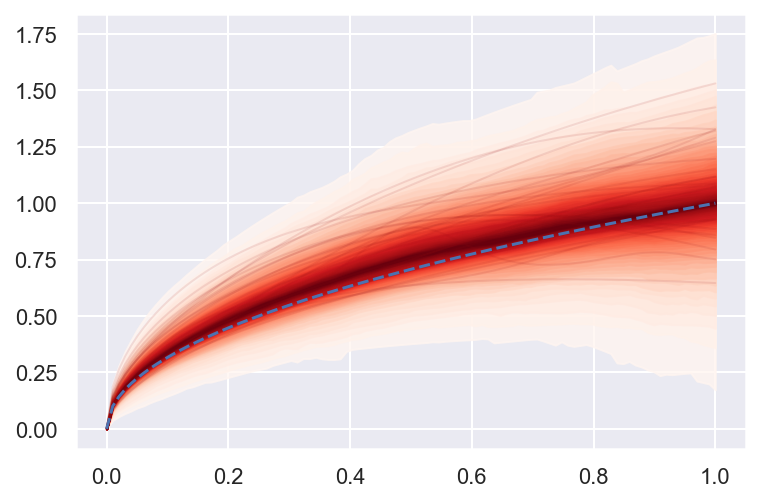

In [45]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_predict, Xtest)
ax.plot(Xtest, u_model(Xtest, theta_model), ls='--');

### Using linear prior

In [46]:
u_model = u_lin
theta_model = None
tau_model = 3.333
X, nuts = run_inference(data=data, u=u_model, theta=theta_model, tau=tau_model)

sample: 100%|██████████| 2000/2000 [05:41<00:00,  5.86it/s, 31 steps of size 9.62e-02. acc. prob=0.97]


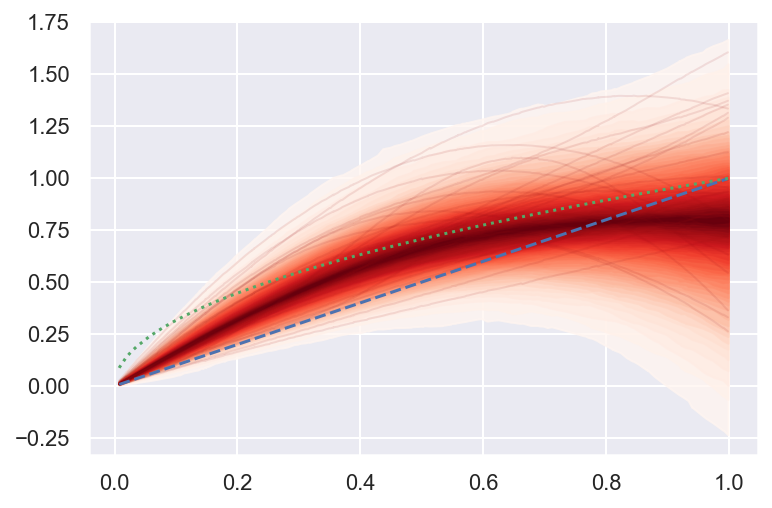

In [52]:
f_samples = nuts.get_samples()["f"]

fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta_model), ls='--');
ax.plot(X, u_data(X, theta_data), ls=':', color='C2');

In [48]:
nuts.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
         eta[0]      0.61      0.64      0.59     -0.37      1.68    818.69      1.00
         eta[1]      0.08      1.00      0.09     -1.45      1.71   1863.40      1.00
         eta[2]      0.04      0.95     -0.01     -1.60      1.65   1980.87      1.00
         eta[3]      0.02      0.98      0.00     -1.44      1.65   2299.11      1.00
         eta[4]      0.01      1.03      0.01     -1.56      1.79   2117.84      1.00
         eta[5]      0.02      1.03     -0.00     -1.73      1.68   1462.08      1.00
         eta[6]     -0.03      0.97     -0.02     -1.53      1.62   2260.31      1.00
         eta[7]     -0.05      1.04     -0.02     -1.89      1.52   2059.28      1.00
         eta[8]     -0.09      1.02     -0.07     -2.03      1.35   1534.76      1.00
         eta[9]     -0.07      1.04     -0.06     -1.67      1.71   1335.34      1.00
        eta[10]     -0.14      1.00     -0.15     -1.

array([<AxesSubplot:title={'center':'kernel_var'}>,
       <AxesSubplot:title={'center':'kernel_length'}>], dtype=object)

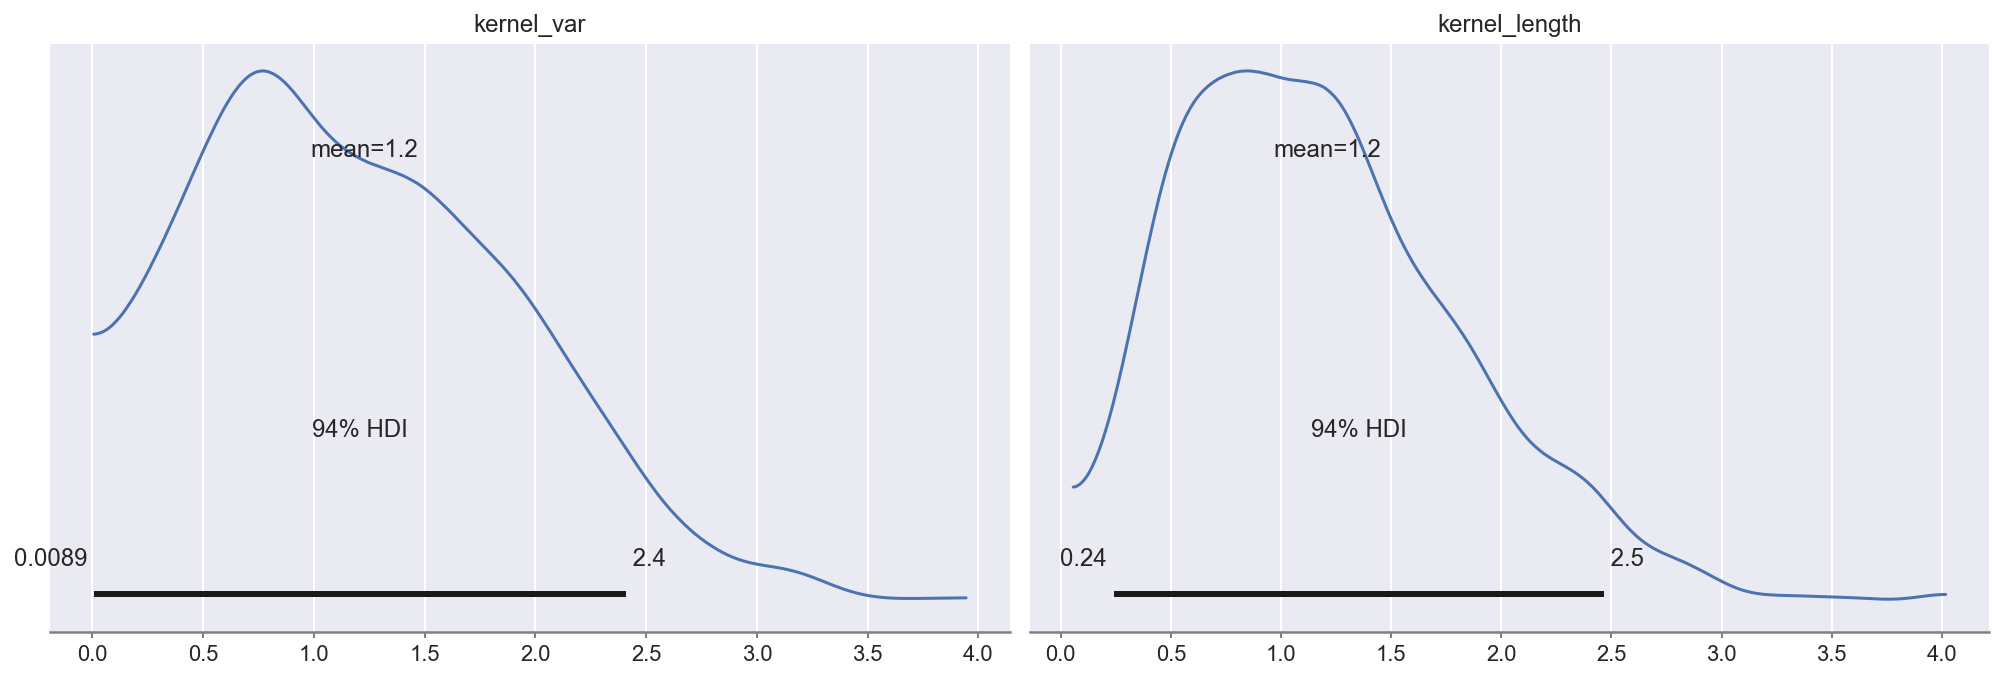

In [49]:
az_samples = az.from_numpyro(nuts)
az.plot_posterior(az_samples, var_names=['kernel_var', 'kernel_length'])

# Sparse

In [53]:
def kernel(X, Xs, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    return jnp.exp(-0.5 * deltaX)

In [66]:
def sparse_model(X, y, p, init_order, u, theta, tau, T, jitter=1e-06):
    
    n = y.shape[0]
    
    var = numpyro.sample("kernel_var", dist.TruncatedNormal(low=0., loc=1., scale=1.))
    length = numpyro.sample("kernel_length", dist.TruncatedNormal(low=0., loc=1., scale=1.))
    
    with numpyro.plate("T", T):
        Xt = numpyro.sample("Xtrain", dist.Uniform(low=0, high=1))
        eta = numpyro.sample('eta', dist.Normal())
        
    Mt = jnp.asarray(u(Xt, theta))
    
    K_factor = Mt[:, None] * Mt
    
    k_XX = K_factor * var **2 * kernel(Xt, Xt, length) + jitter*jnp.eye(T)
    L = jnp.linalg.cholesky(k_XX)
    L_dot_eta = jnp.dot(L, eta)
    # f = Mt + L_dot_eta

    Mp = jnp.array(u(X, theta))
    K_Xp_factor = Mt[:, None] * Mp
    
    K_Xp =  K_Xp_factor * var**2 * kernel(Xt, X, length)
    A = jax.scipy.linalg.solve_triangular(L, K_Xp, lower=True)
    v = jax.scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

    f_predict = numpyro.deterministic("f", Mp + A.T.dot(v))
    
    est_eu_sorted =  p * f_predict    
    est_eu = est_eu_sorted[init_order]
    est_diff_eu = est_eu[n:] - est_eu[:n]
    
    numpyro.sample("obs", dist.Bernoulli(logits=tau * est_diff_eu), obs=y)

In [74]:
def run_inference_sparse(data, u, theta, tau, T):
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)

    X = jnp.array(x_sorted)
    uX = jnp.array(u_model(X, theta_model))
    P = jnp.array(p_sorted)
    Y = jnp.array(y)
    
    # Set random seed for reproducibility.
    rng_key = random.PRNGKey(123)

    nuts = MCMC(NUTS(sparse_model, target_accept_prob=0.9, max_tree_depth=10, 
                     init_strategy=init_to_uniform(radius=1),
                     adapt_mass_matrix=True,
                     dense_mass=False),
                num_samples=1000, num_warmup=1000)
    nuts.run(rng_key, X=X, y=Y, p=P, init_order=undo_sorted, 
             u=u, theta=theta, tau=tau_model,
         T=T)
    return X, nuts

## With 'good' prior

In [75]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [76]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=200, seed=123)

In [77]:
optimize(data, u_m=u_pow)

array([3.97130767, 0.48028541])

In [78]:
u_model = u_pow
theta_model = 0.5
tau_model = 3.333

In [79]:
X, nuts = run_inference_sparse(data=data, T=50,
                            u=u_model, theta=theta_model, tau=tau_model)

sample: 100%|██████████| 2000/2000 [09:59<00:00,  3.34it/s, 255 steps of size 1.57e-02. acc. prob=0.89]


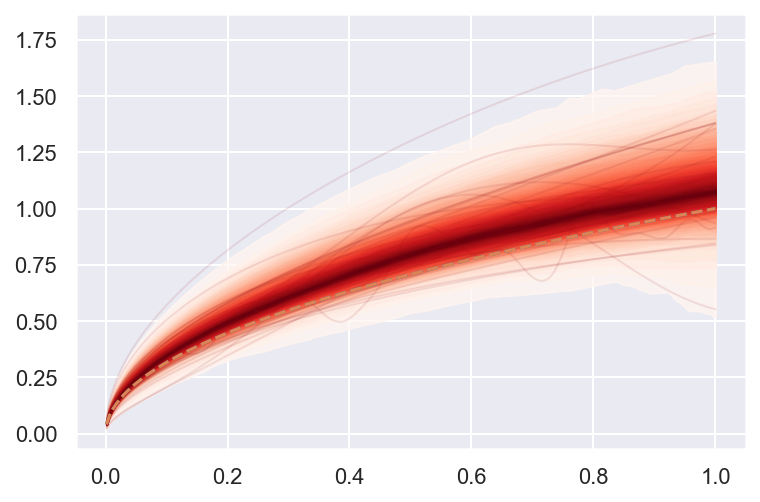

In [82]:
f_samples = nuts.get_samples()["f"]

fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta_model), ls='--');
ax.plot(X, u_data(X, theta_data), ls='--');

array([<AxesSubplot:title={'center':'kernel_var'}>,
       <AxesSubplot:title={'center':'kernel_length'}>], dtype=object)

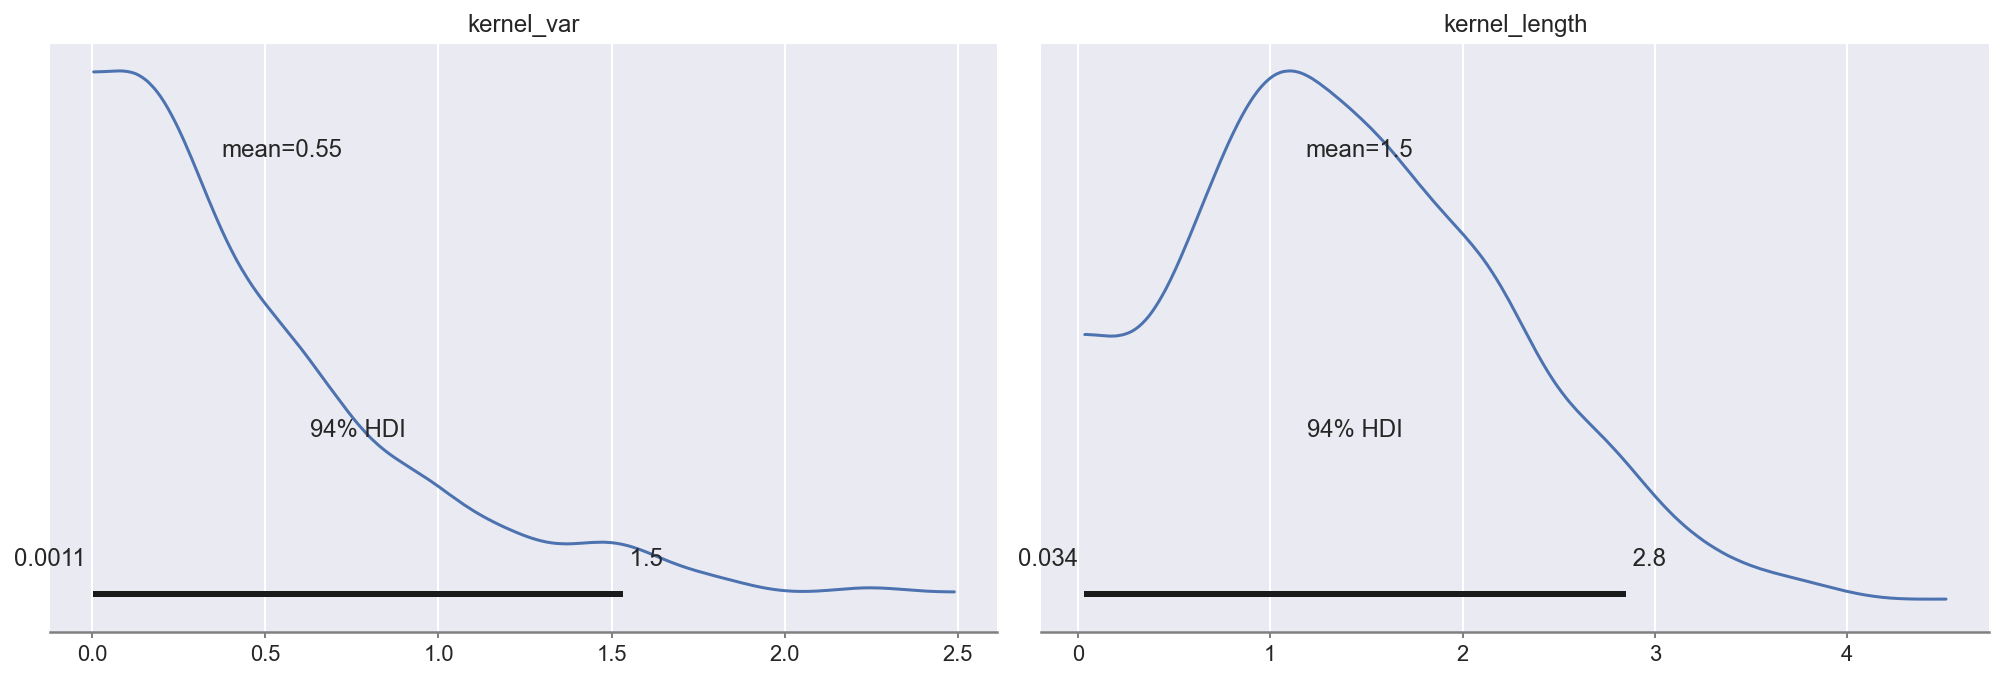

In [83]:
az_samples = az.from_numpyro(nuts)
az.plot_posterior(az_samples, var_names=['kernel_var', 'kernel_length'])

## With linear prior

In [84]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [85]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=200, seed=123)

In [86]:
optimize(data, u_m=u_pow)

array([3.97130767, 0.48028541])

In [87]:
u_model = u_lin
theta_model = None
tau_model = 3.333

In [ ]:
X, nuts = run_inference_sparse(data=data, T=50,
                            u=u_model, theta=theta_model, tau=tau_model)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
f_samples = nuts.get_samples()["f"]

fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
ax.plot(X, u_model(X, theta_model), ls='--');
ax.plot(X, u_data(X, theta_data), ls='--');

In [ ]:
az_samples = az.from_numpyro(nuts)
az.plot_posterior(az_samples, var_names=['kernel_var', 'kernel_length'])

# Kernel experiments

In [222]:
def square_dist(X, Xs, length):
    """
    From Pymc3
    """
    X /= length
    X2 = jnp.sum(jnp.square(X), 1)
    if Xs is None:
        sqd = -2.0 * jnp.dot(X, jnp.transpose(X)) + (
            jnp.reshape(X2, (-1, 1)) + jnp.reshape(X2, (1, -1))
        )
    else:
        Xs = jnp.mul(Xs, 1.0 / length)
        Xs2 = jnp.sum(jnp.square(Xs), 1)
        sqd = -2.0 * jnp.dot(X, jnp.transpose(Xs)) + (
            jnp.reshape(X2, (-1, 1)) + aet.reshape(Xs2, (1, -1))
        )
    return jnp.clip(sqd, 0.0, jnp.inf)

In [234]:
def sliceX(X, Xs, input_dim=1):
    if input_dim != X.shape[-1]:
                warnings.warn(
                    f"Only {self.input_dim} column(s) out of {X.shape[-1]} are"
                    " being used to compute the covariance function. If this"
                    " is not intended, increase 'input_dim' parameter to"
                    " the number of columns to use. Ignore otherwise.",
                    UserWarning,
                )
    X = X[:, np.arange(input_dim)]
    if Xs is not None:
        Xs = Xs[:, np.arange(input_dim)]
    return X, Xs

In [235]:
def exp_quad(X, length, Xs=None):
    X, Xs = sliceX(X, Xs)
    return jnp.exp(-0.5 * square_dist(X, Xs, length))

In [244]:
def kernel(X, Xs, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    return jnp.exp(-0.5 * deltaX)

In [256]:
%%time
kernel(np.arange(3), np.arange(3), length=1)

CPU times: user 1.5 ms, sys: 607 µs, total: 2.1 ms
Wall time: 2.19 ms


DeviceArray([[1.        , 0.60653067, 0.13533528],
             [0.60653067, 1.        , 0.60653067],
             [0.13533528, 0.60653067, 1.        ]], dtype=float32)

In [257]:
xx = jnp.array(np.arange(3).reshape(-1, 1))

In [258]:
%%time
exp_quad(xx, 1)

CPU times: user 5.92 ms, sys: 1.9 ms, total: 7.81 ms
Wall time: 6.12 ms


DeviceArray([[1.        , 0.60653067, 0.13533528],
             [0.60653067, 1.        , 0.60653067],
             [0.13533528, 0.60653067, 1.        ]], dtype=float32)